In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from backpack import backpack, extend
from backpack.extensions import DiagHessian

In [8]:
# Create base images (happy, sad, neutral faces)
def create_base_images():
    base_images = np.zeros((3, 16, 16))
    
    # Happy face (index 0)
    base_images[0, 4, 4] = base_images[0, 4, 11] = 1  # Eyes
    base_images[0, 10, 5:11] = 1  # Smile (curved upwards)
    base_images[0, 11, 4] = base_images[0, 11, 11] = 1  # Smile curve corners
    base_images[0, 12, 3] = base_images[0, 12, 12] = 1  # Smile curve corners
    
    # Sad face (index 1)
    base_images[1, 4, 4] = base_images[1, 4, 11] = 1  # Eyes
    base_images[1, 11, 5:11] = 1  # Frown (curved downwards)
    base_images[1, 10, 4] = base_images[1, 10, 11] = 1  # Smile curve corners
    base_images[1, 9, 3] = base_images[1, 9, 12] = 1  # Smile curve corners

    # Neutral face (index 2)
    base_images[2, 4, 4] = base_images[2, 4, 11] = 1  # Eyes
    base_images[2, 10, 4:12] = 1  # Straight line for mouth
    
    return base_images

# Generate noisy dataset
def generate_dataset(base_images, label=-1, num_samples=3000, noise_level=0.2):
    images = []
    labels = []
    in_label=label
    for i in range(num_samples):
        if in_label == -1:
            label = np.random.randint(0, 3)
        img = base_images[label] + noise_level * np.random.randn(16, 16)
        img = np.clip(img, 0, 1)  # Keep pixel values between 0 and 1
        images.append(img)
        labels.append(label)
    return torch.tensor(images, dtype=torch.float32).unsqueeze(1), torch.tensor(labels, dtype=torch.long)

# Define simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 3)  # 3 classes
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Compute Hessian
def compute_hessian(model, criterion, data, target):
    model.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    hessian = []
    for grad in grad_params:
        grad_vector = grad.view(-1)
        row = []
        for g in grad_vector:
            second_derivative = torch.autograd.grad(g, model.parameters(), retain_graph=True)
            row.append(torch.cat([sd.contiguous().view(-1) for sd in second_derivative]))
        hessian.append(torch.stack(row))
    return torch.cat(hessian, dim=0)

# Training function
def train(model, train_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


In [13]:

# Main execution

base_images = create_base_images()
n_samples = 3000
images_h, labels_h = generate_dataset(base_images, label=0, num_samples=n_samples//3)
images_s, labels_s = generate_dataset(base_images, label=1, num_samples=n_samples//3)
images_n, labels_n = generate_dataset(base_images, label=2, num_samples=n_samples//3)
train_dataset_h = TensorDataset(images_h, labels_h)
train_dataset_s = TensorDataset(images_s, labels_s)
train_dataset_n = TensorDataset(images_n, labels_n)
train_dataset = train_dataset_h + train_dataset_s
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Flatten(),                    # Flatten the 16x16x16 feature map
    nn.Linear(16 * 16 * 16, 64),
    nn.ReLU(),
    nn.Linear(64, 3)                 # 3 classes
)

model = extend(model)
criterion = nn.CrossEntropyLoss()
lossfunc = extend(criterion)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Loss: 0.0005
Epoch [2/5], Loss: 0.0002
Epoch [3/5], Loss: 0.0001
Epoch [4/5], Loss: 0.0001
Epoch [5/5], Loss: 0.0000


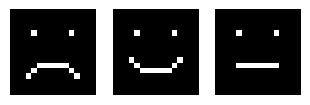

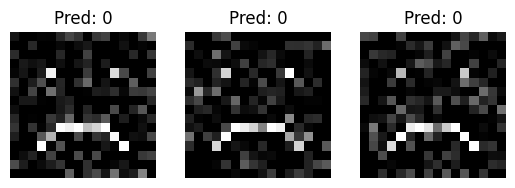

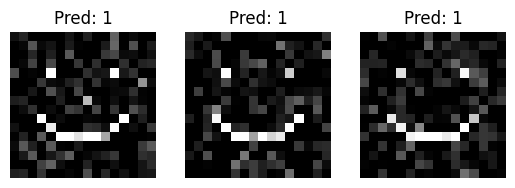

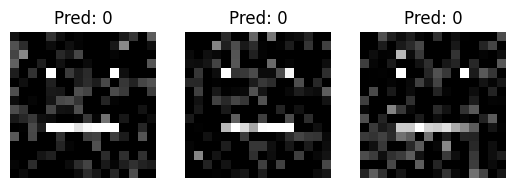

In [14]:

# Test model on some samples
test_samples_h, _ = generate_dataset(base_images, label=0, num_samples=3)
test_samples_s, _ = generate_dataset(base_images, label=1, num_samples=3)
test_samples_n, _ = generate_dataset(base_images, label=2, num_samples=3)
test_samples = torch.cat((test_samples_h, test_samples_s, test_samples_n), dim=0)

with torch.no_grad():
    predictions = model(test_samples).argmax(dim=1)

# Show some test images
for i in range(3):
    plt.subplot(1, 5, i+1)
    plt.imshow(base_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

# Show some test images
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[i].item()}')
    plt.axis('off')
plt.show()
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[3+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[3+i].item()}')
    plt.axis('off')
plt.show()
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[6+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[6+i].item()}')
    plt.axis('off')
plt.show()


In [15]:
for param in model.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([8, 1, 3, 3])
<class 'torch.Tensor'> torch.Size([8])
<class 'torch.Tensor'> torch.Size([16, 8, 3, 3])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([64, 4096])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([3, 64])
<class 'torch.Tensor'> torch.Size([3])


In [24]:
from torch import cat

test_samples, test_labels = generate_dataset(base_images, num_samples=10)
predictions = model(test_samples)
loss = lossfunc(predictions, test_labels)

# 5) Compute the diagonal Hessian with BackPACK
with backpack(DiagHessian()):
    loss.backward()

for name, param in model.named_parameters():
    print(name)
    print(".grad.shape:             ", param.grad.shape)
    print(".diag_h.shape:           ", param.diag_h.shape)

diag_hessian_exact_vector = cat([p.diag_h.flatten() for p in model.parameters()])
print(diag_hessian_exact_vector)

0.weight
.grad.shape:              torch.Size([8, 1, 3, 3])
.diag_h.shape:            torch.Size([8, 1, 3, 3])
0.bias
.grad.shape:              torch.Size([8])
.diag_h.shape:            torch.Size([8])
2.weight
.grad.shape:              torch.Size([16, 8, 3, 3])
.diag_h.shape:            torch.Size([16, 8, 3, 3])
2.bias
.grad.shape:              torch.Size([16])
.diag_h.shape:            torch.Size([16])
5.weight
.grad.shape:              torch.Size([64, 4096])
.diag_h.shape:            torch.Size([64, 4096])
5.bias
.grad.shape:              torch.Size([64])
.diag_h.shape:            torch.Size([64])
7.weight
.grad.shape:              torch.Size([3, 64])
.diag_h.shape:            torch.Size([3, 64])
7.bias
.grad.shape:              torch.Size([3])
.diag_h.shape:            torch.Size([3])
tensor([1.2765e-03, 1.2286e-03, 1.2786e-03,  ..., 9.6283e-04, 9.6283e-04,
        5.0793e-09])


In [6]:
from torch.autograd.functional import hessian
torch.cuda.empty_cache()


def gauss_newton_approx(model, criterion, data, target):
    model = model
    data = data
    target = target

    model.zero_grad()
    output = model(data)
    loss = criterion(output, target)

    def loss_function(params):
        # Load parameters into model
        idx = 0
        i=0
        for param in model.parameters():
            if i<6:
                i+=1
                continue
            param_length = param.numel()
            param.data = params[idx : idx + param_length].view(param.shape)
            idx += param_length

        output = model(data)
        return criterion(output, target)
    
        # Flatten the parameters into a single vector
    params = torch.cat([p.flatten() for p in list(model.parameters())[6:8]])

    # Compute Hessian
    return hessian(loss_function, params)
    
def gauss_newton_approx_(model, criterion, data, target):
    model.zero_grad()
    output = model(data)
    loss = criterion(output, target)

    def loss_function(params):
        # Load parameters into model
        idx = 0
        for param in model.parameters():
            param_length = param.numel()
            param.data = params[idx : idx + param_length].view(param.shape)
            idx += param_length

        output = model(data)
        return criterion(output, target)

    # Flatten the parameters into a single vector
    params = torch.cat([p.flatten() for p in model.parameters()])

    # Compute Hessian
    return  hessian(loss_function, params)

test_samples, test_labels = generate_dataset(base_images, num_samples=10)
train_images=torch.cat([images_h,images_n,images_s])
train_labels=torch.cat([labels_h,labels_n,labels_s])
#hessian_matrix = gauss_newton_approx(model, criterion, test_samples, test_labels)
hessian_matrix = gauss_newton_approx(model, criterion, train_images, train_labels)
print("Hessian matrix shape:", hessian_matrix.shape)

Hessian matrix shape: torch.Size([195, 195])


In [7]:
# Compute eigenvalues and eigenvectors
eigvals, eigvecs = torch.linalg.eig(hessian_matrix)

print("Eigenvalues:")
print(eigvals)  # Complex tensor if needed

print("\nEigenvectors:")
print(eigvecs)  # Columns are eigenvectors

Eigenvalues:
tensor([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+